In [ ]:
import time
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from skimage.transform import resize
from skimage import feature
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
import zipfile
zip_path = '/content/traffic_sign_detection (2).zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall()


In [ ]:
#Get information from 1 image
xml_file = '/content/annotations/road0.xml'
tree = ET.parse(xml_file)
root = tree.getroot()
folder_name = root.find('folder').text
file_name = root.find('filename').text

print(root)
print(file_name)
print(folder_name)

for obj in root.findall('object'):
  class_name = obj.find('name').text

  x_min = int(obj.find('bndbox/xmin').text)
  y_min = int(obj.find('bndbox/ymin').text)
  x_max = int(obj.find('bndbox/xmax').text)
  y_max = int(obj.find('bndbox/ymax').text)

  print(f'Classname :{class_name}')
  print(f'Bounding box: {(x_min, y_min, x_max, y_max)}')

<Element 'annotation' at 0x7ed0f21e67a0>
road0.png
images
Classname :trafficlight
Bounding box: (98, 62, 208, 232)


In [ ]:
#Get image from all the dataset
annotation_dir = 'annotations'
img_dir = 'images'

img_list = []
label_list = []

for xml_file in os.listdir(annotation_dir):
  xml_filepath = os.path.join(annotation_dir, xml_file)
  tree = ET.parse(xml_filepath)
  root = tree.getroot()

  folder = root.find('folder').text
  img_filename = root.find('filename').text
  img_filepath = os.path.join(img_dir, img_filename)
  img = cv2.imread(img_filepath)

  for obj in root.findall('object'):
    classname = obj.find('name').text
    if classname == 'trafficlight':
      continue
    xmin = int(obj.find('bndbox/xmin').text)
    ymin = int(obj.find('bndbox/ymin').text)
    xmax = int(obj.find('bndbox/xmax').text)
    ymax = int(obj.find('bndbox/ymax').text)

    object_img = img[ymin:ymax, xmin:xmax]
    img_list.append(object_img)
    label_list.append(classname)


In [ ]:
print(f'Image shape: {img_list[0].shape}')#The shape is (height, width, channel). If we want to put data into SVM, we must reshape the image to len(image) = 1

Image shape: (34, 34, 3)


In [ ]:
#Preprocessing
flattened_img = img_list[0].flatten()
print(f'Shape after flattened : {flattened_img.shape}')
 #Too complicated, so we preprocess the image before flattening
#We use HoG here (Histogram of Oriented Gradients)

Shape after flattened : (3468,)


In [ ]:
#Preprocessing Image
#HoG : Histogram of Oriented Gradients
#Step 1 : use 2 Kernel Sobel , make convolution calculation to the image (Gx, Gy) ,
#then we find 2 matrix : Gradient Magnitude (G = sqrt(Gx^2 + Gy^2)) and Gradient Direction (theta = arctan(Gy/Gx))

#Step 2 : Next, we create a 1D vector consisting of 9 elements representing the value range of the direction matrix
#The gradient is in the range [0,180]. Divide the vector into 9 intervals, each interval is given
#called 1 bin. This vector is called the Histogram of Gradient vector.

#Step 3 :Referring the 2 matrices found above to the representative vector, we have 2 cases of value assignment:
## Gradient Direction has a magnitude that coincides with bin (0,20,40...) => always assign the corresponding value to
#Gradient Magnitude into that bin. (For example, the blue position in figure 21)
#Gradient Direction has a magnitude within the bin range => use the following interpolation formula to find it
#assigned value:
#X l-1 = (X1 - X) / (X1-X0) * magnitude
#X l = (X - X0) /(X1-X0) * magnitude

#Step 4 : normalize cell into 2x2 blocks, formula : h / |h|^2



In [ ]:
def preprocess_img(img):
  if len(img.shape) > 2:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = img.astype(np.float32)

  resized_img = resize(
      img, output_shape = (32, 32), anti_aliasing = True
  ) #HOC vectors will have the same shape

  hog_features = feature.hog(
      resized_img,
      orientations = 9,
      pixels_per_cell = (8, 8),
      cells_per_block = (2, 2),
      transform_sqrt = True,
      block_norm = 'L2',
      feature_vector = True
  )

  return hog_features

In [ ]:
img_features_list = []
for img in img_list:
  hog_features = preprocess_img(img)
  img_features_list.append(hog_features)

img_features = np.array(img_features_list)
print(img_features.shape)

(1074, 324)


In [ ]:
# Numbering Label

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_list)

In [ ]:
encoded_labels

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
#Split dataset for training
random_state = 0
test_size = 0.3
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(img_features,encoded_labels, test_size = test_size, random_state = random_state, shuffle = is_shuffle)



In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
#Training

clf = SVC(
    kernel = 'rbf',
    random_state = random_state,
    probability = True,
    C = 0.5
)
clf.fit(X_train, y_train)

SVC(C=0.5, probability=True, random_state=0)

In [ ]:
y_pred = clf.predict(X_val)
score = accuracy_score(y_pred, y_val)
print(f'Accuracy: {score}')

Accuracy: 0.9721362229102167


In [ ]:
#Localization
def sliding_window(img, window_sizes, stride,scale_factor):
  img_height, img_width = img.shape[:2]
  windows = []
  for window_size in window_sizes:
    window_height, window_width = window_size
    for ymin in range(0, img_height - window_height + 1, stride):
      for xmin in range(0, img_width - window_width +1, stride):
        xmax = xmin + window_width
        ymax = ymin + window_width

        windows.append([xmin, ymin, xmax, ymax])
  return windows

#Here, we use Pyramid Images for scaling the image , so that the small object
#will be bigger, fit easier to the sliding window

def pyramid(img, scale = 0.8, min_size = (30, 30)):
  acc_scale = 1.0
  pyramid_imgs = [(img, acc_scale)]

  i = 0
  while True:
    acc_scale = acc_scale * scale
    h = int(img.shape[0] * acc_scale)
    w = int(img.shape[1] * acc_scale)
    if h < min_size[1] or w < min_size[0]:
      break
    img = cv2.resize(img, (w, h))
    pyramid_imgs.append((img, acc_scale * (scale ** i)))
    i+= 1

  return pyramid_imgs

In [ ]:
#Build NMS(Non Maximal Supression)
#Compute IoU (Intersection of Union)
def compute_iou(bbox, bboxes, bbox_area, bboxes_area):
  xxmin = np.maximum(bbox[0], bboxes[:, 0])
  yymin = np.maximum(bbox[1], bboxes[:, 1])
  xxmax = np.minimum(bbox[2], bboxes[:, 2])
  yymax = np.minimum(bbox[3], bboxes[:, 3])

  w = np.maximum(0, xxmax - xxmin + 1)
  h = np.maximum(0, yymax - yymin +1)
  intersection = w*h
  iou = intersection / (bbox_area + bboxes_area - intersection)

  return iou

In [ ]:
def nms(bboxes, iou_threshold):
  if not bboxes:
    return []

  scores = np.array([bbox[5] for bbox in bboxes])
  sorted_indices = np.argsort(scores)[::-1]

  xmin = np.array([bbox[0] for bbox in bboxes])
  ymin = np.array([bbox[1] for bbox in bboxes])
  xmax = np.array([bbox[2] for bbox in bboxes])
  ymax = np.array([bbox[3] for bbox in bboxes])

  areas = (xmax - xmin +1) * (ymax - ymin +1)
  keep = []

  while sorted_indices.size > 0:
    i = sorted_indices[0]
    keep.append(i)

    iou = compute_iou(
        [xmin[i], ymin[i], xmax[i], ymax[i]],
        np.array(
            [
                xmin[sorted_indices[1:]],
                ymin[sorted_indices[1:]],
                xmax[sorted_indices[1:]],
                ymax[sorted_indices[1:]]
            ]
        ).T,
        areas[i],
        areas[sorted_indices[1:]]
    )
    idx_to_keep = np.where(iou <= iou_threshold)[0]
    sorted_indices = sorted_indices[idx_to_keep + 1]

  return [bboxes[i] for i in keep]

In [ ]:
def visualize_box(img, bboxes, label_encoder):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  bboxes = nms(bboxes, iou_threshold = 0.1)
  for box in bboxes:
    xmin, ymin, xmax, ymax , predict_id, conf_score = box
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    classname = label_encoder.inverse_transform([predict_id])[0]
    label = f'{classname} {conf_score:.2f}'

    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

    cv2.rectangle(img, (xmin, ymin - 20), (xmin + w, ymin), (0, 255, 0), -1)
    cv2.putText(img, label, (xmin, ymin -5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)

  plt.imshow(img)
  plt.axis('off')
  plt.show()

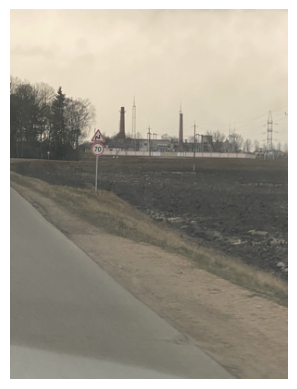

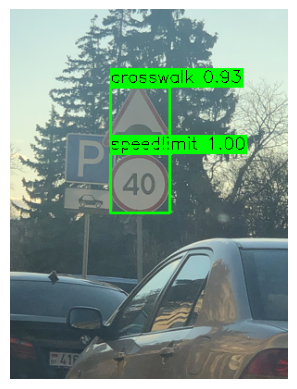

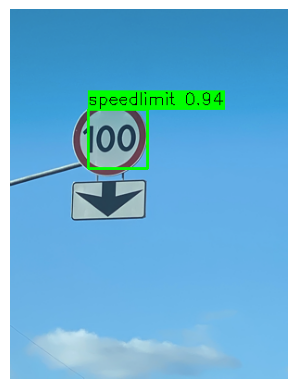

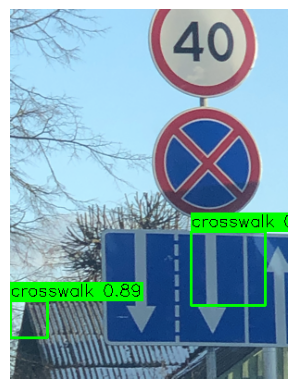

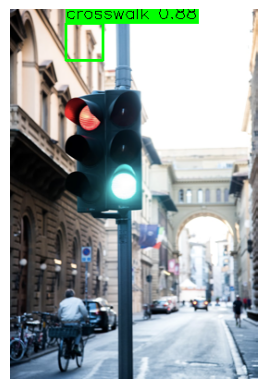

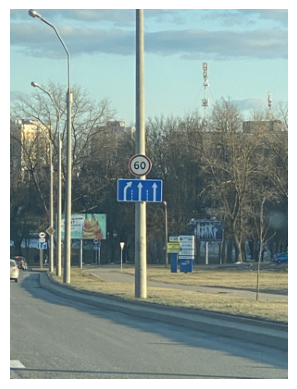

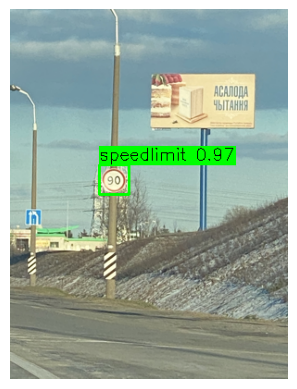

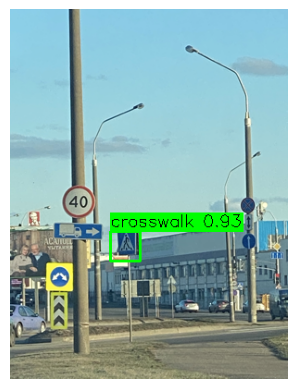

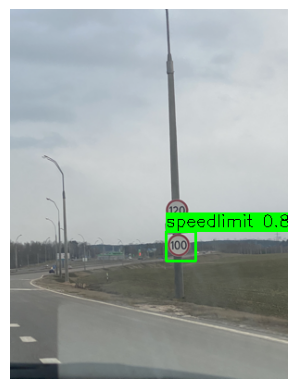

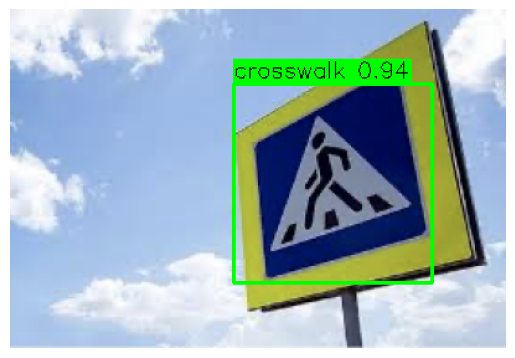

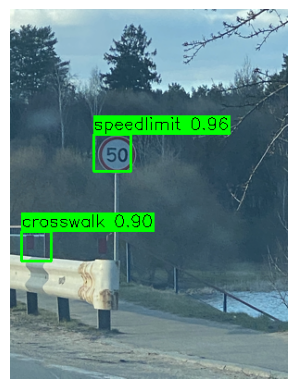

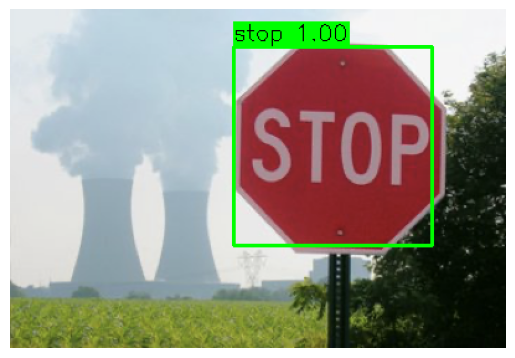

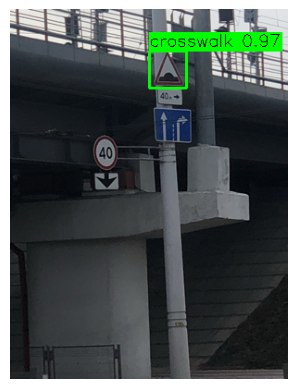

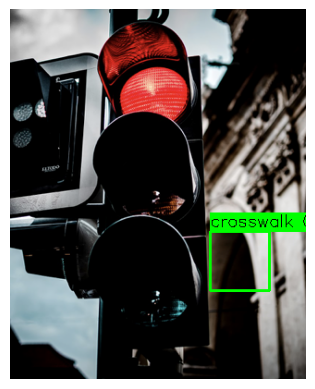

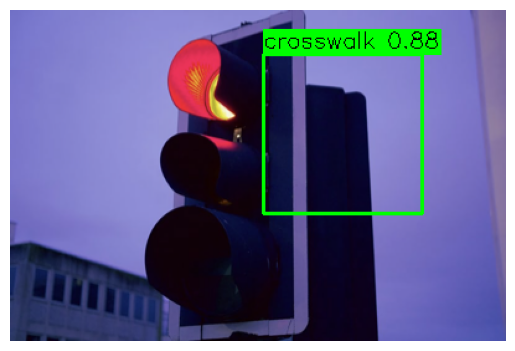

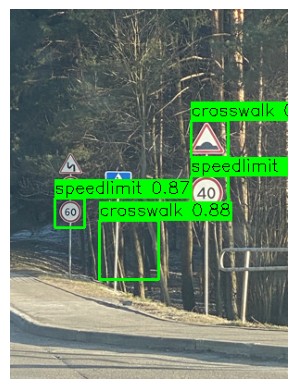

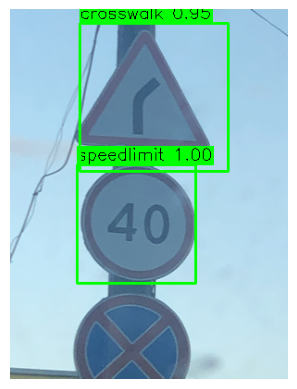

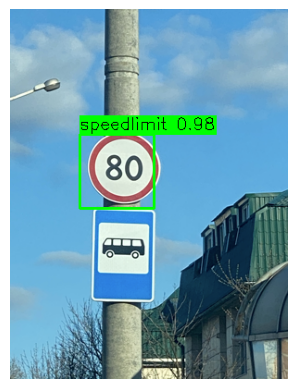

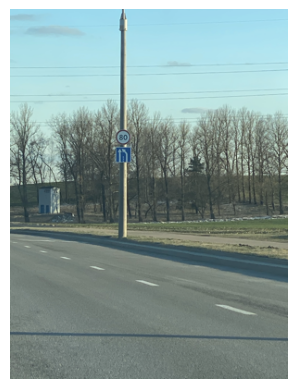

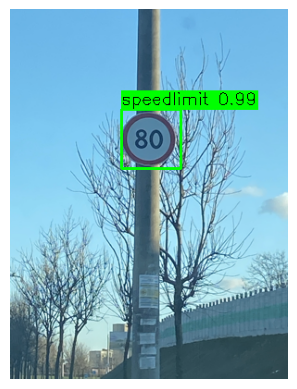

In [ ]:
img_filename_list = os.listdir(img_dir)[:20]
conf_threshold = 0.87
stride = 12
window_size = [(32, 32), (64, 64), (128,128)]
for img_filename in img_filename_list:
  start_time = time.time()
  img_filepath = os.path.join(img_dir, img_filename)
  bboxes = []
  img = cv2.imread(img_filepath)
  pyramid_imgs = pyramid(img)
  for pyramid_img_info in pyramid_imgs:
    pyramid_img, scale_factor = pyramid_img_info
    window_list = sliding_window(
        pyramid_img,
        window_sizes = window_size,
        stride = stride,
        scale_factor = scale_factor
    )
    for window in window_list:
      xmin, ymin, xmax, ymax = window
      object_img = pyramid_img[ymin:ymax, xmin:xmax]
      preprocessed_img = preprocess_img(object_img)
      normalized_img = scaler.transform([preprocessed_img])[0]
      decision = clf.predict_proba([normalized_img])[0]
      if np.all(decision < conf_threshold):
        continue
      else:
        predict_id = np.argmax(decision)
        conf_score = decision[predict_id]
        xmin = int(xmin / scale_factor)
        ymin = int(ymin / scale_factor)
        xmax = int(xmax / scale_factor)
        ymax = int(ymax / scale_factor)
        bboxes.append([xmin, ymin, xmax, ymax, predict_id, conf_score])
  visualize_box(img, bboxes, label_encoder)